# Cuban Human Brain Mapping Project Exploratory Data Analysis

**Update**: *November 24th, 2021*

#### Cuban Neuroscience Center

This dataset encompasses the Cuban Brain Mapping database, featuring data from 279 subjects. It includes both EEG and MRI data (T1, DWI, and Fieldmap).

**Cuban Brain Mapping EEG Protocol**:
- **Total EEG Recording Duration**: 27 minutes maximum.
- **Eyes Closed**: 15 minutes.
- **Eyes Open**: 5 minutes.
- **Hyperventilation**: 3 minutes.
- **Recuperation**: 3 minutes.


In [1]:
import mne 
import cerebro
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [2]:
chbmp_filepath = Path('/Users/luiscamargo/Developer/datasets/chbmp')

In [3]:
subject_df = pd.read_csv('/Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/ds_bids_cbm_loris_24_11_21/participants.tsv', delimiter='\t')
subject_df.sex.value_counts()

sex
M    178
F    101
Name: count, dtype: int64

In [4]:
edfs  = sorted([file for file in chbmp_filepath.glob("**/*.edf")])
channel_tsvs = sorted([file for file in chbmp_filepath.glob("**/*task-protmap_channels.tsv")])
events_tsvs = sorted([file for file in chbmp_filepath.glob("**/*task-protmap_events.tsv")])


len(edfs) == len(channel_tsvs) == len(events_tsvs)

True

In [5]:
channel_df = pd.concat((pd.read_csv(tsv, delimiter='\t') for tsv in channel_tsvs))
events_df = pd.concat((pd.read_csv(tsv, delimiter='\t') for tsv in events_tsvs))





In [6]:
channel_df['status'].value_counts()

status
good    20045
bad       312
Name: count, dtype: int64

In [7]:
events_df

,onset,duration,trial_type,value,sample
0,0.005,0,eyes_closed,65,1
1,608.470,0,eyes_open,66,121694
2,621.115,0,eyes_closed,65,124223
3,634.250,0,eyes_open,66,126850
4,652.610,0,eyes_closed,65,130522
...,...,...,...,...,...
27,1091.105,0,hyperventilation_2,68,218221
28,1148.565,0,discontinuity,2,229713
29,1153.935,0,discontinuity,2,230787
30,1168.975,0,hyperventilation_3,69,233795


In [8]:
events_df['duration'] = events_df['onset'].shift(-1) - events_df['onset']


In [9]:
events_df

,onset,duration,trial_type,value,sample
0,0.005,608.465,eyes_closed,65,1
1,608.470,12.645,eyes_open,66,121694
2,621.115,13.135,eyes_closed,65,124223
3,634.250,18.360,eyes_open,66,126850
4,652.610,17.155,eyes_closed,65,130522
...,...,...,...,...,...
27,1091.105,57.460,hyperventilation_2,68,218221
28,1148.565,5.370,discontinuity,2,229713
29,1153.935,15.040,discontinuity,2,230787
30,1168.975,74.970,hyperventilation_3,69,233795


In [28]:
events_df.iloc[-1, 0]

1243.945

In [27]:
raw.times[-1]

1513.995

In [66]:
for idx, edf in enumerate(edfs[:1]):
    
    chbmp_record = str(edfs[1])

    cer = cerebro.Cerebro()
    raw = cer.load_data(chbmp_record, source = 'chbmp')
    
    total_time = raw.times[-1]

    channel_df = pd.read_csv(channel_tsvs[idx], delimiter='\t') 
    events_df = pd.read_csv(events_tsvs[idx], delimiter='\t') 
    
    events_df['duration'] = events_df['onset'].shift(-1) - events_df['onset']
    
    events_df.iloc[-1, 1] = total_time - events_df.iloc[-1, 0]
    
    annots = mne.Annotations(events_df['onset'].tolist(), events_df['duration'].tolist(), events_df['trial_type'].tolist())

    raw.set_annotations(annots)
    
    



Extracting EDF parameters from /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/ds_bids_cbm_loris_24_11_21/sub-CBM00002/eeg/sub-CBM00002_task-protmap_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322399  =      0.000 ...  1611.995 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [67]:
annots[0]

OrderedDict([('onset', 0.005),
             ('duration', 608.465),
             ('description', 'eyes_closed'),
             ('orig_time', None)])

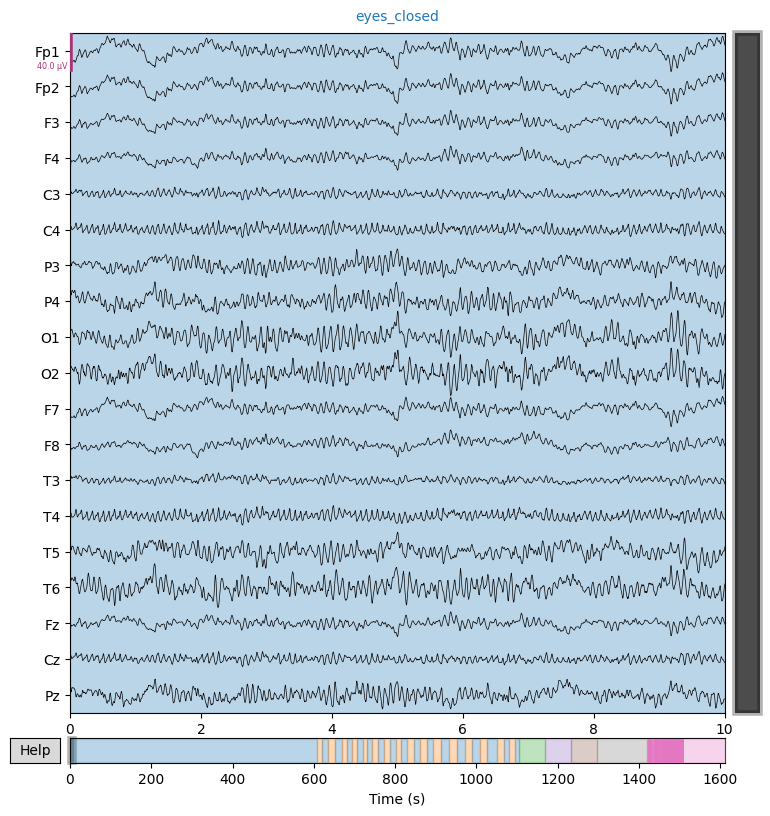

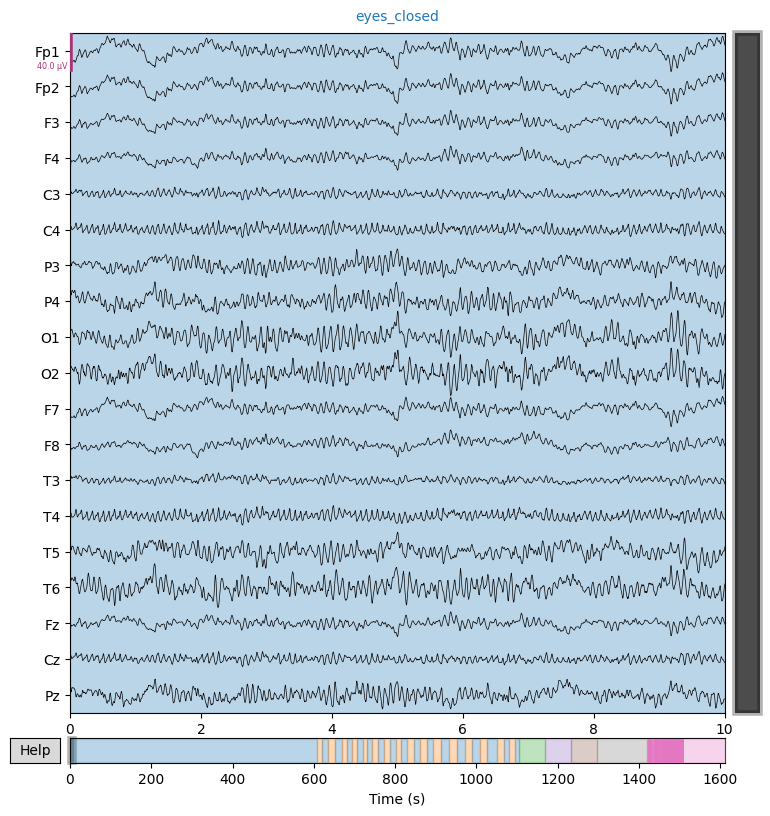

In [68]:
raw.plot()

In [41]:
raws = raw.crop_by_annotations(annots)

Effective window size : 10.240 (s)


/Users/luiscamargo/Library/Caches/pypoetry/virtualenvs/cerebro-dMdwJK-v-py3.11/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


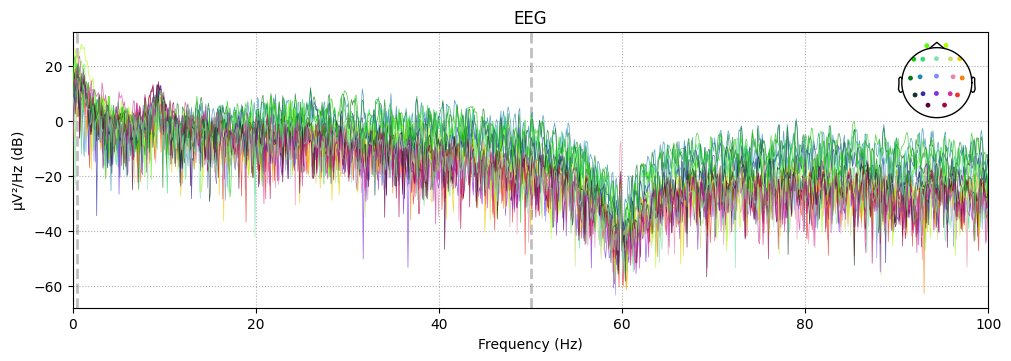

In [49]:
raws[1].compute_psd().plot()

Effective window size : 10.240 (s)


/Users/luiscamargo/Library/Caches/pypoetry/virtualenvs/cerebro-dMdwJK-v-py3.11/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


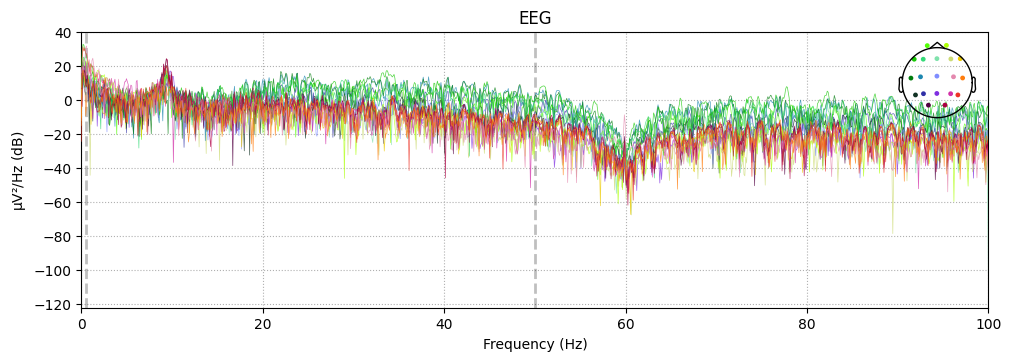

In [50]:
raws[2].compute_psd().plot()

Effective window size : 7.320 (s)


/Users/luiscamargo/Library/Caches/pypoetry/virtualenvs/cerebro-dMdwJK-v-py3.11/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


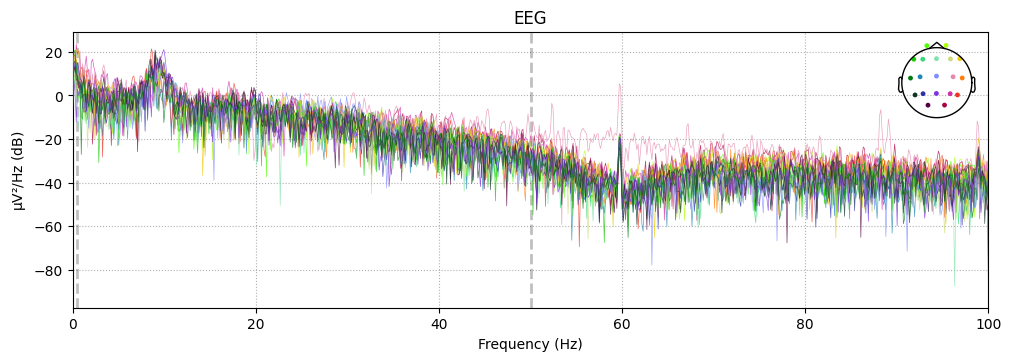

In [47]:
raws[-1].compute_psd().plot()

### Synchronous alpha activity is greater in the eyes closed segments compared to eyes open.

In [81]:
for idx, edf in enumerate(edfs):
    
    chbmp_record = str(edf)
    
    new_fname = edf.name.replace('.edf', '.fif')

    # Wrapped around MNE, use to parse CHBMP edfs in the 10-20 system
    cer = cerebro.Cerebro()
    raw = cer.load_data(chbmp_record, source = 'chbmp')
    
    total_time = raw.times[-1]

    # Obtain data regarding eeg events and channel signal quality
    channel_df = pd.read_csv(channel_tsvs[idx], delimiter='\t') 
    events_df = pd.read_csv(events_tsvs[idx], delimiter='\t') 
    
    events_df['duration'] = events_df['onset'].shift(-1) - events_df['onset']
    
    events_df.iloc[-1, 1] = total_time - events_df.iloc[-1, 0]
    
    # Set annotations in raw file
    annots = mne.Annotations(events_df['onset'].tolist(), events_df['duration'].tolist(), events_df['trial_type'].tolist())
    raw.set_annotations(annots)
    
    # Analyze the first eyes closed segment only.
    epochs = raw.crop_by_annotations(annots)
    
    # The largest segment should be eyes closed, check if condition is true, if so save file in fif format.
    annots_df = annots.to_data_frame()
    eyes_closed_idx = np.argmax(annots_df['duration'])
    if annots_df['description'].loc[eyes_closed_idx] == 'eyes_closed':
        epochs[eyes_closed_idx].save(f'/Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/eyes_closed_eeg/{new_fname}', overwrite=True)

Extracting EDF parameters from /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/ds_bids_cbm_loris_24_11_21/sub-CBM00001/eeg/sub-CBM00001_task-protmap_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302799  =      0.000 ...  1513.995 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/eyes_closed_eeg/sub-CBM00001_task-protmap_eeg.fif
Closing /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/eyes_closed_eeg/sub-CBM00001_task-protmap_eeg.fif
[done]
Extracting EDF parameters from /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/ds_bids_cbm_loris_24_11_21/sub-CBM00002/eeg/sub-CBM00002_task-protmap_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322399  =      0.000 ...  1611.995 secs...
EEG channel ty

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319999  =      0.000 ...  1599.995 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/eyes_closed_eeg/sub-CBM00017_task-protmap_eeg.fif
Closing /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/eyes_closed_eeg/sub-CBM00017_task-protmap_eeg.fif
[done]
Extracting EDF parameters from /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/ds_bids_cbm_loris_24_11_21/sub-CBM00018/eeg/sub-CBM00018_task-protmap_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 359599  =      0.000 ...  1797.995 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/eyes_cl

[done]
Extracting EDF parameters from /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/ds_bids_cbm_loris_24_11_21/sub-CBM00033/eeg/sub-CBM00033_task-protmap_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 324999  =      0.000 ...  1624.995 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/eyes_closed_eeg/sub-CBM00033_task-protmap_eeg.fif
Closing /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/eyes_closed_eeg/sub-CBM00033_task-protmap_eeg.fif
[done]
Extracting EDF parameters from /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/ds_bids_cbm_loris_24_11_21/sub-CBM00034/eeg/sub-CBM00034_task-protmap_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 318399  =      0.000 ...  1591.995 secs...
EEG cha

Closing /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/eyes_closed_eeg/sub-CBM00049_task-protmap_eeg.fif
[done]
Extracting EDF parameters from /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/ds_bids_cbm_loris_24_11_21/sub-CBM00050/eeg/sub-CBM00050_task-protmap_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 199999  =      0.000 ...   999.995 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Extracting EDF parameters from /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/ds_bids_cbm_loris_24_11_21/sub-CBM00051/eeg/sub-CBM00051_task-protmap_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299999  =      0.000 ...  1499.995 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Extracting EDF paramete

[done]
Extracting EDF parameters from /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/ds_bids_cbm_loris_24_11_21/sub-CBM00065/eeg/sub-CBM00065_task-protmap_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 287599  =      0.000 ...  1437.995 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Extracting EDF parameters from /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/ds_bids_cbm_loris_24_11_21/sub-CBM00066/eeg/sub-CBM00066_task-protmap_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301199  =      0.000 ...  1505.995 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/eyes_closed_eeg/sub-CBM00066_task-protmap_eeg.fif
Closing /Users/luiscama

Applying average reference.
Applying a custom ('EEG',) reference.
Extracting EDF parameters from /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/ds_bids_cbm_loris_24_11_21/sub-CBM00084/eeg/sub-CBM00084_task-protmap_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 369399  =      0.000 ...  1846.995 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Extracting EDF parameters from /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/ds_bids_cbm_loris_24_11_21/sub-CBM00085/eeg/sub-CBM00085_task-protmap_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320799  =      0.000 ...  1603.995 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/eyes_closed_ee

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 241199  =      0.000 ...  1205.995 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/eyes_closed_eeg/sub-CBM00101_task-protmap_eeg.fif
Closing /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/eyes_closed_eeg/sub-CBM00101_task-protmap_eeg.fif
[done]
Extracting EDF parameters from /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/ds_bids_cbm_loris_24_11_21/sub-CBM00102/eeg/sub-CBM00102_task-protmap_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 353199  =      0.000 ...  1765.995 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/eyes_cl

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310399  =      0.000 ...  1551.995 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Extracting EDF parameters from /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/ds_bids_cbm_loris_24_11_21/sub-CBM00118/eeg/sub-CBM00118_task-protmap_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 317199  =      0.000 ...  1585.995 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/eyes_closed_eeg/sub-CBM00118_task-protmap_eeg.fif
Closing /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/eyes_closed_eeg/sub-CBM00118_task-protmap_eeg.fif
[done]
Extracting EDF parameters from /Users/luiscamargo/Developer/datasets/chbmp/CH

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297599  =      0.000 ...  1487.995 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/eyes_closed_eeg/sub-CBM00130_task-protmap_eeg.fif
Closing /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/eyes_closed_eeg/sub-CBM00130_task-protmap_eeg.fif
[done]
Extracting EDF parameters from /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/ds_bids_cbm_loris_24_11_21/sub-CBM00131/eeg/sub-CBM00131_task-protmap_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326799  =      0.000 ...  1633.995 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Extracting EDF parameters from /Users/luiscamargo/Developer/datasets/chbmp/CH

Creating raw.info structure...
Reading 0 ... 362999  =      0.000 ...  1814.995 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/eyes_closed_eeg/sub-CBM00146_task-protmap_eeg.fif
Closing /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/eyes_closed_eeg/sub-CBM00146_task-protmap_eeg.fif
[done]
Extracting EDF parameters from /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/ds_bids_cbm_loris_24_11_21/sub-CBM00147/eeg/sub-CBM00147_task-protmap_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 338799  =      0.000 ...  1693.995 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /Users/luiscamargo/Developer/datasets/chbmp/CHBMP_EEG_and_MRI/eyes_closed_eeg/sub-CBM00147_task-protmap_eeg.fif
Closing /

/var/folders/s4/2dvkb3_d5zn9ps_0lx2bx0fm0000gn/T/ipykernel_70573/3055758725.py:21: RuntimeWarning: Omitted 2 annotation(s) that were outside data range.
  raw.set_annotations(annots)
/var/folders/s4/2dvkb3_d5zn9ps_0lx2bx0fm0000gn/T/ipykernel_70573/3055758725.py:21: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annots)


ValueError: tmax (1568.275) must be less than or equal to the max time (1567.9950 s)

In [69]:
epochs

[<RawEDF | sub-CBM00012_task-protmap_eeg.edf, 19 x 2010 (10.0 s), ~326 kB, data loaded>,
 <RawEDF | sub-CBM00012_task-protmap_eeg.edf, 19 x 119477 (597.4 s), ~17.3 MB, data loaded>,
 <RawEDF | sub-CBM00012_task-protmap_eeg.edf, 19 x 3641 (18.2 s), ~569 kB, data loaded>,
 <RawEDF | sub-CBM00012_task-protmap_eeg.edf, 19 x 2731 (13.7 s), ~433 kB, data loaded>,
 <RawEDF | sub-CBM00012_task-protmap_eeg.edf, 19 x 2223 (11.1 s), ~358 kB, data loaded>,
 <RawEDF | sub-CBM00012_task-protmap_eeg.edf, 19 x 3027 (15.1 s), ~477 kB, data loaded>,
 <RawEDF | sub-CBM00012_task-protmap_eeg.edf, 19 x 2689 (13.4 s), ~427 kB, data loaded>,
 <RawEDF | sub-CBM00012_task-protmap_eeg.edf, 19 x 3018 (15.1 s), ~476 kB, data loaded>,
 <RawEDF | sub-CBM00012_task-protmap_eeg.edf, 19 x 3374 (16.9 s), ~529 kB, data loaded>,
 <RawEDF | sub-CBM00012_task-protmap_eeg.edf, 19 x 2669 (13.3 s), ~424 kB, data loaded>,
 <RawEDF | sub-CBM00012_task-protmap_eeg.edf, 19 x 3202 (16.0 s), ~503 kB, data loaded>,
 <RawEDF | sub-CB